# Create agent populations
In this notebook, we will create agent populations with increasingly large distance from the original agent.
We will proceed to doing this as follows:
1. To induce diversity from the original agent, we shuffle the position of words in semantics spaces. We could have added noise to the coordinates, but we are interested in keeping the performance of individual agents constant, and adding parametric noise to the coordinates will alter the topology of the space, which changes performance patterns;
2. To induce *increasingly high* levels of diversity, we will define a range of *shuffling thresholds*, and only shuffle animals whose distance is lower than that shuffling thresholds;
3. We will then set the population which is least different from the original agent as the reference population and compute pairwise distances between agents in this population, and agents in increasingly different populations;
4. On the basis of this, we will estimate 20 *new* shuffling thresholds, to yield new populations whose average distance from the original space is linearly increasing;
5. Finally, we will sample 100 pairs of agents for each population, such that one of the agents belongs to the reference population, and the other to the population at stake;
6. This will yield 20 groups of agents whose distance from the reference population increases linearly. This are what we call "diversity levels".

Let's do this step by step.

In [5]:
import glob
from simcat.utils import compute_thresholds
from simcat.agents import Agent
import itertools
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import curve_fit
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from multiprocessing import Pool
from sklearn import decomposition
from pathlib import Path
import json

### Preprocessing

First, let's define some hyperparameters and useful variables.

In [3]:
nr_init_shuffling_thresholds = 15
pop_size = 100
ID = "experiments"

Get animal names, distance thresholds, and mapping between animals and positional index for each animal

In [8]:
models = [f"../models/baseline/wiki_euclidean_distance.tsv"]
animals = pd.read_csv(f"../models/animal_list.csv")
thresholds = compute_thresholds(
    models, q=[round(n, 2) for n in np.arange(0.05, 1.0, 0.05)], round_at=5
)
animals_idx_dict = json.load(open(f"../models/baseline/wiki_mapping.json"))

Import the vector space and the original distance matrix

In [9]:
vecs_scaled = pd.read_csv(
    f"../models/baseline/wiki_vectors_scaled.tsv", sep="\t", index_col=0
).values
dists = pd.read_csv(models[0], sep="\t", index_col=0)
dists.values[np.tril_indices(dists.values.shape[0], 0)] = np.nan

Now we transform the distacne matrix into a long-form dataframe, we bin the distance values based on linearly-spaced values, and we check how many pairs of animals we would shuffle if we used these.

In [5]:
long_dists = pd.melt(dists.reset_index(), id_vars="index").dropna()
long_dists.columns = ["animal_1", "animal_2", "distance"]
long_dists["distance_bins"] = pd.cut(
    long_dists.distance,
    nr_init_shuffling_thresholds,
    labels=range(nr_init_shuffling_thresholds),
).astype(float)
long_dists["distance_qbins"] = pd.qcut(
    long_dists.distance,
    nr_init_shuffling_thresholds,
    labels=range(nr_init_shuffling_thresholds),
).astype(float)

In [6]:
categories = pd.cut(
    long_dists.distance,
    nr_init_shuffling_thresholds,
    retbins=True,
    labels=range(nr_init_shuffling_thresholds),
)[1]

In [7]:
long_dists.groupby("distance_bins").count()

,animal_1,animal_2,distance,distance_qbins
distance_bins,,,,
0.0,10,10,10,10
1.0,15,15,15,15
2.0,43,43,43,43
3.0,100,100,100,100
4.0,295,295,295,295
5.0,859,859,859,859
6.0,1814,1814,1814,1814
7.0,3679,3679,3679,3679
8.0,5734,5734,5734,5734


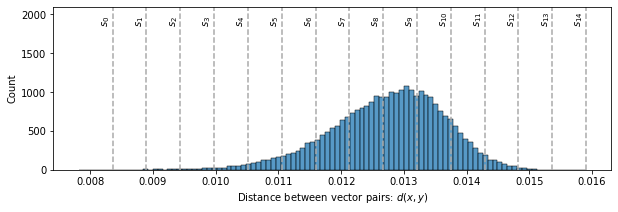

In [8]:
fig, ax = plt.subplots(figsize=(10, 3))
for idx, c in enumerate(categories[1:]):
    plt.axvline(c, linestyle="--", color="darkgrey")
    plt.annotate(
        f"$s_{{{idx}}}$",
        xy=(c - 0.0002, 1900),
        xycoords="data",
        rotation=90,
        fontsize=10,
    )
sns.histplot(long_dists.distance)
plt.ylim(0, 2100)
plt.xlabel("Distance between vector pairs: $d(x,y)$")
plt.savefig("../figures/baseline_distance_dist.png", dpi=300, bbox_inches="tight")
plt.show()

Alright! Now we have an initial set of shuffling thresholds.
Let's create output paths where we will store the noised agents, before we start instantiating new agents.

In [8]:
for p in ["noised_vectors", "noised_distance_matrices", "mappings"]:
    opath = Path("..") / "models" / "noised_agents" / p
    opath.mkdir(parents=True, exist_ok=True)

### Generate agents from initial thresholds
Great, now we can use these shuffling thresholds to generate a range of agents.
The population generated using the first shuffling threshold ($s_{0}$) will be set as the reference population.
We will then pair agents from this population ($A_{0}$) with agents from all remaining populations ($A_{n}$), and compute the average Euclidean distance between each population $A_{n}$ and $A_{0}$.
This will likely be non-linear, but it will give use a way to estimate the relation between shuffling thresholds and distances between agents, which we can then use to sample new shuffling thresholds yielding populations whose distances from the reference populations are linearly spaced.
The reason why we want this is that we want to understand the effect of diversity on behavior by sampling the distribution of possible distances in an optimal way.

In [9]:
noised_dists = []
noised_vecs = []

for b in range(nr_init_shuffling_thresholds):
    print(f"Processing bin {b+1} of {nr_init_shuffling_thresholds}")

    # pick animals who should be shuffled
    bin_df = long_dists[(long_dists["distance_bins"] <= b)]

    for a_idx in range(pop_size):
        # Get 70% of the pairs that can be shuffled
        subthr_pairs = list(
            bin_df.sample(frac=0.7)[["animal_1", "animal_2"]].to_records(index=False)
        )

        # Identify new indices of each animal after shuffling is performed
        idx_dict_copy = animals_idx_dict.copy()
        for animal_1, animal_2 in subthr_pairs:
            idx_1 = idx_dict_copy[animal_1]
            idx_2 = idx_dict_copy[animal_2]
            idx_dict_copy[animal_1] = idx_2
            idx_dict_copy[animal_2] = idx_1
        new_idx = dict(sorted(idx_dict_copy.items(), key=lambda item: item[1])).keys()

        # Used calculated indices to modify the original vector space
        fname = f"{space}_{b}_{a_idx}.tsv"
        agent_vec_df = pd.DataFrame(vecs_scaled.copy())
        agent_vec_df.index = new_idx
        agent_vec_df = agent_vec_df.reindex(animals_idx_dict.keys())
        noised_vecs.append((a_idx, b, agent_vec_df))

        # Compute euclidean distances between pairs of animals in the new vector space
        agent_dist = euclidean_distances(agent_vec_df.values, agent_vec_df.values) / 400
        agent_dist_df = pd.DataFrame(agent_dist.round(5))
        agent_dist_df.index = agent_vec_df.index
        agent_dist_df.columns = agent_dist_df.index
        noised_dists.append((a_idx, b, agent_dist_df))

Processing bin 1 of 15
Processing bin 2 of 15
Processing bin 3 of 15
Processing bin 4 of 15
Processing bin 5 of 15
Processing bin 6 of 15
Processing bin 7 of 15
Processing bin 8 of 15
Processing bin 9 of 15
Processing bin 10 of 15
Processing bin 11 of 15
Processing bin 12 of 15
Processing bin 13 of 15
Processing bin 14 of 15
Processing bin 15 of 15


Now we compute pairwise distances between agents in the first population (which differs only minimally from the original population) and all other populations.
We do so on all possible pairs of agents.

Let's define a function that computes such distances. Note that the distance between two agents is defined as the average Euclidean distance between vectors corresponding to the same animals across the two spaces.

In [10]:
def _compute_distance(pair):
    """Computes distance between pair of agents"""
    distance = np.mean(np.sqrt(np.sum(np.square(pair[0][2] - pair[1][2]), axis=1)))
    noise_level1 = pair[0][1]
    noise_level2 = pair[1][1]
    idx1 = pair[0][0]
    idx2 = pair[1][0]
    return (idx1, idx2, noise_level1, noise_level2, distance)

Let's now use this function to compute distances between all pairs of agents.
We use multiprocessing to speed up the process.

In [11]:
pair_dists = {}
for b in range(nr_init_shuffling_thresholds):
    print(f"Bin: {b}")
    ref_vecs = [nv for nv in noised_vecs if nv[1] == 0]
    b_vecs = [nv for nv in noised_vecs if nv[1] == b]
    b_combs = list(itertools.product(b_vecs, ref_vecs))
    pool = Pool(processes=60)
    b_dists = pool.map(_compute_distance, b_combs)
    pair_dists[b] = b_dists
    pool.close()

Bin 0
Bin 1
Bin 2
Bin 3
Bin 4
Bin 5
Bin 6
Bin 7
Bin 8
Bin 9
Bin 10
Bin 11
Bin 12
Bin 13
Bin 14


Now, we compute an average of the distances for each population $A_{1:n}$.

In [12]:
dmeans = []
for nl, vals in pair_dists.items():
    dmeans.append(np.mean([v[-1] for v in vals]))

Great, now we have a bunch of shuffling thresholds, and, for each of this, the value of the average distance between agents generated with thart shuffling threshold and agents in the reference populations. Let's model this as a generalized logistic function with an offset parameter. We use `curve_fit` from `scipy` to estimate the necessary parameters, and we then plot the function.

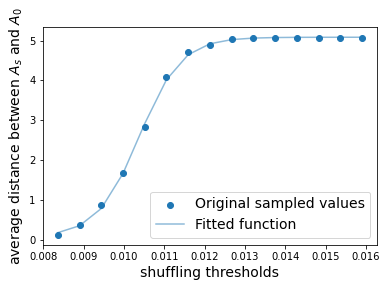

In [22]:
def logifunc(x, A, x0, k, off):
    return A / (1 + np.exp(-k * (x - x0))) + off


popt, pcov = curve_fit(logifunc, categories[1:], dmeans)
plt.scatter(categories[1:], dmeans, label="Original sampled values")
plt.plot(
    categories[1:],
    logifunc(categories[1:], *popt),
    "-",
    label="Fitted function",
    alpha=0.5,
)
plt.xlabel("shuffling thresholds", fontsize=14)
plt.ylabel("average distance between $A_{s}$ and $A_{0}$", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("../figures/refitted_values.png", dpi=300, bbox_inches="tight")

Now that we have estimated a function that yields average distances between $A_{0}$ and all other populations, given the shuffling thresholds, we can invert this function to get new shuffling thresholds. Let's do so.

In [14]:
def rev_logifunc(y, A, x0, k, off):
    return x0 - (np.log(A / (y - off) - 1) / k)

We then take linearly spaced values in distances, and estimate the corresponding shuffling thresholds.

In [15]:
A = popt[0]
x0 = popt[1]
k = popt[2]
off = popt[3]
agent_distances = np.linspace(np.min(dmeans) + 0.1, np.max(dmeans), num=20)
animal_distances = [
    rev_logifunc(y, A, x0, k, off) for y in list(agent_distances)
]  # shuffling thresholds

(Let's also print the parameters we estimated)

In [16]:
A.round(3), x0.round(2), k.round(2), off.round(2)

(5.008, 0.01, 1925.07, 0.07)

And here are our resampled values!

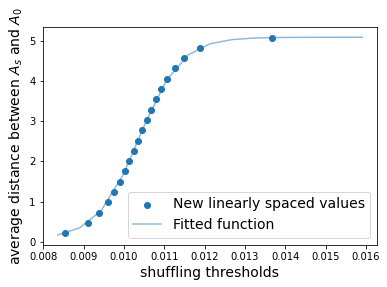

In [23]:
plt.scatter(animal_distances, agent_distances, label="New linearly spaced values")
plt.plot(
    categories[1:],
    logifunc(categories[1:], *popt),
    "-",
    label="Fitted function",
    alpha=0.5,
)
plt.xlabel("shuffling thresholds", fontsize=14)
plt.ylabel("average distance between $A_{s}$ and $A_{0}$", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("../figures/refitted_values_2.png", dpi=300, bbox_inches="tight")

We can plot the relation between the rank of the distance value and the distance value itself to show that distances are indeed linear.

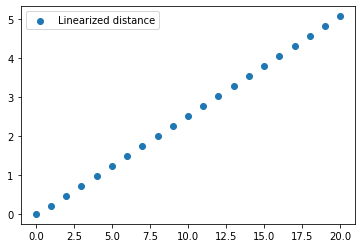

In [18]:
plt.scatter(
    range(21), [categories[1]] + list(agent_distances), label="Linearized distance"
)
plt.legend()

### Generate final agent populations

Great! Now we are ready to generate 20 agent populations, whose average distances from our reference population $A_{0}$ are linearly spaced. We use the same procedure we applied earlier, to generate the original populations.

In [21]:
noised_dists = []
noised_vecs = []

for b, x in enumerate([categories[1]] + list(animal_distances)):  # for each threshold
    print(f"Processing bin {b+1} of {len(animal_distances)}")
    # find pairs that can be swapped
    bin_df = long_dists[(long_dists["distance"] <= x)]

    for a_idx in range(pop_size):
        # sample 70% of those
        subthr_pairs = list(
            bin_df.sample(frac=0.7)[["animal_1", "animal_2"]].to_records(index=False)
        )

        idx_dict_copy = animals_idx_dict.copy()

        # get new indices for all animals
        for animal_1, animal_2 in subthr_pairs:
            idx_1 = idx_dict_copy[animal_1]
            idx_2 = idx_dict_copy[animal_2]
            idx_dict_copy[animal_1] = idx_2
            idx_dict_copy[animal_2] = idx_1
        new_idx = dict(sorted(idx_dict_copy.items(), key=lambda item: item[1])).keys()

        # save the resulting mapping between animals and their positional indices
        fname = f"{space}_{b}_{a_idx}"
        json.dump(
            idx_dict_copy, open(f"../models/noised_agents/mappings/{fname}.json", "w")
        )

        # apply reindexing to vector spaces, to get new spaces (and save)
        agent_vec_df = pd.DataFrame(vecs_scaled.copy())
        agent_vec_df.index = new_idx
        agent_vec_df = agent_vec_df.reindex(animals_idx_dict.keys())
        agent_vec_df.to_csv(
            f"../models/noised_agents/noised_vectors/{fname}.tsv", sep="\t"
        )
        noised_vecs.append((a_idx, b, agent_vec_df))

        # compute euclidean distances on new vector spaces (and save)
        agent_dist = euclidean_distances(agent_vec_df.values, agent_vec_df.values) / 400
        agent_dist_df = pd.DataFrame(agent_dist.round(5))
        agent_dist_df.index = agent_vec_df.index
        agent_dist_df.columns = agent_dist_df.index
        agent_dist_df.to_csv(
            f"../models/noised_agents/noised_distance_matrices/{fname}.tsv", sep="\t"
        )
        noised_dists.append((a_idx, b, agent_dist_df))

Processing bin 1 of 20
Processing bin 2 of 20
Processing bin 3 of 20
Processing bin 4 of 20
Processing bin 5 of 20
Processing bin 6 of 20
Processing bin 7 of 20
Processing bin 8 of 20
Processing bin 9 of 20
Processing bin 10 of 20
Processing bin 11 of 20
Processing bin 12 of 20
Processing bin 13 of 20
Processing bin 14 of 20
Processing bin 15 of 20
Processing bin 16 of 20
Processing bin 17 of 20
Processing bin 18 of 20
Processing bin 19 of 20
Processing bin 20 of 20
Processing bin 21 of 20


### Sample pairs of agents
Now we are ready to create pairs that will play the VFT together!
Let's first create a dictionary whose keys are the ranks of the shuffling thresholds ($1:20$) and the values store information about each possible pair of agents (where the first is drawn from $A_{0}$, the second from $A_{i}$, where $i$ is the shuffling threshold) and their distance.

In [22]:
pair_dists = {}
for b in range(21):
    print(f"Bin {b}")
    ref_vecs = [nv for nv in noised_vecs if nv[1] == 0]
    b_vecs = [nv for nv in noised_vecs if nv[1] == b]
    b_combs = list(itertools.product(b_vecs, ref_vecs))
    pool = Pool(processes=60)
    b_dists = pool.map(_compute_distance, b_combs)
    pair_dists[b] = b_dists
    pool.close()

Bin 0
Bin 1
Bin 2
Bin 3
Bin 4
Bin 5
Bin 6
Bin 7
Bin 8
Bin 9
Bin 10
Bin 11
Bin 12
Bin 13
Bin 14
Bin 15
Bin 16
Bin 17
Bin 18
Bin 19
Bin 20


Now, based on the dictionary we have created earlies, let's sample `pop_size` agents for each population, yielding 20 groups including pairs of agents that operationalize out between-pair incremental diversity manipulation.

In [23]:
dist_dfs = []

# Shape the dictionary ito a pandas df
for idx, k in enumerate(pair_dists.keys()):
    pair_dist_df = pd.DataFrame(
        pair_dists[k],
        columns=["idx1", "idx2", "noise_level1", "noise_level2", "distance"],
    )
    for c in ["idx1", "idx2", "noise_level1", "noise_level2"]:
        pair_dist_df[c] = pair_dist_df[c].astype(str)
    print(pair_dist_df.shape[0])  # just checking that we have all agents in place
    dist_dfs.append(pair_dist_df)
pairs_dist_df = pd.concat(dist_dfs, ignore_index=True)

# Add identifiers for each pair
pairs_dist_df["fname_1"] = (
    "wiki_" + pairs_dist_df["noise_level1"] + "_" + pairs_dist_df["idx1"] + ".tsv"
)
pairs_dist_df["fname_2"] = (
    "wiki_" + pairs_dist_df["noise_level2"] + "_" + pairs_dist_df["idx2"] + ".tsv"
)

# Now sample pop_size pairs
sampled_lst = []
for idx, b in enumerate(range(21)):
    b_sampled = pairs_dist_df[pairs_dist_df["noise_level1"] == str(b)].sample(
        n=pop_size
    )
    sampled_lst.append(b_sampled)
sampled_all = pd.concat(sampled_lst, ignore_index=False)

# Save information about sampled pairs!
sampled_all.to_csv(f"../models/noised_agents/sampled_pairs.tsv", sep="\t")

10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000


We are done! We have created agent populations for our experiments! :)